# Stock Market Prediction And Forecasting Using Stacked LSTM

## Get Data

### one way

In [1]:

import pandas as pd

In [2]:
key=''
stock = 'TCS.BSE'

In [3]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ stock +'&outputsize=compact&apikey='+key#+'&datatype=csv'

In [4]:
import urllib.request

weburl = urllib.request.urlopen(url)
data = weburl.read()


In [5]:
from ast import literal_eval

data = literal_eval(data.decode('utf-8'))

In [6]:
# import json

# result = json.dumps(data, indent=4, sort_keys=True)

In [7]:
df = pd.DataFrame(data.get('Time Series (Daily)'))
df = df.T
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2021-05-21,3065.0,3087.8999,3055.3501,3080.3999,3080.3999,25700,0.0000,1.0
2021-05-20,3074.0,3087.55,3053.0,3060.0,3060.0,44081,0.0000,1.0
2021-05-19,3080.0,3118.0,3066.05,3081.95,3081.95,63943,0.0000,1.0
2021-05-18,3095.0,3123.0,3078.7,3089.3501,3089.3501,71234,0.0000,1.0
2021-05-17,3060.0,3077.0,3035.6499,3069.8,3069.8,101499,0.0000,1.0


In [8]:
df.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. adjusted close',
       '6. volume', '7. dividend amount', '8. split coefficient'],
      dtype='object')

In [9]:
df = df.rename(columns={'1. open':'open','2. high':'high','3. low':'low','4. close':'close','6. volume':'volume'})
df = df [['open','high','low','close','volume']]
df.head()

,open,high,low,close,volume
2021-05-21,3065.0,3087.8999,3055.3501,3080.3999,25700
2021-05-20,3074.0,3087.55,3053.0,3060.0,44081
2021-05-19,3080.0,3118.0,3066.05,3081.95,63943
2021-05-18,3095.0,3123.0,3078.7,3089.3501,71234
2021-05-17,3060.0,3077.0,3035.6499,3069.8,101499


### second way

In [10]:
# import os

# # os.environ['StockAPI1'] = ''
# key = os.getenv('StockAPI1')


In [11]:
stock = 'TCS.BSE'

from datetime import datetime
sdate = datetime(2018,6,1)
edate = datetime(2021,4,30)

In [12]:

import pandas_datareader.data as web
df = web.DataReader(stock, 'av-daily', start = sdate, end = edate, api_key = key)

## EDA

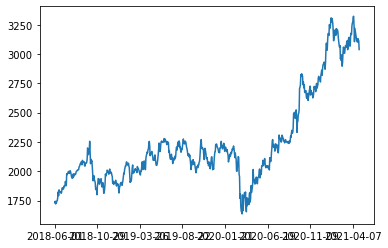

In [13]:
df['close'].plot()

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df_sc = scaler.fit_transform(np.array(df['close']).reshape(-1,1))


In [15]:
train_size = int(len(df_sc)*0.85)
test_size = len(df_sc) - train_size

train_data = df_sc[:train_size,:] 
test_data = df_sc[train_size:,:]

In [16]:
train_data.shape

(608, 1)

In [17]:
k = np.arange(1,21)
k

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [18]:
def create_dataset(data,step=1):
    a=[]
    b=[]
    for i in range(len(data)-step):
        a.append(data[i:i+step])
        b.append(data[i+step])
    return np.array(a),np.array(b)

In [19]:
# how many previous days to consider
back_days = 30

In [20]:
xtrain,ytrain = create_dataset(train_data,back_days)

In [21]:
xtest,ytest = create_dataset(test_data,back_days)

In [22]:
xtrain.shape

(578, 30, 1)

In [23]:
ytrain.shape

(578, 1)

In [24]:
xtest.shape

(78, 30, 1)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [26]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(back_days,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=500,batch_size=32,verbose=1)

Epoch 1/500
19/19 [==============================] - 5s 93ms/step - loss: 0.0387 - val_loss: 0.1102
Epoch 2/500
19/19 [==============================] - 1s 31ms/step - loss: 0.0051 - val_loss: 0.0324
Epoch 3/500
19/19 [==============================] - 1s 32ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 4/500
19/19 [==============================] - 1s 32ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 5/500
19/19 [==============================] - 1s 31ms/step - loss: 0.0029 - val_loss: 0.0079
Epoch 6/500
19/19 [==============================] - 1s 31ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 7/500
19/19 [==============================] - 1s 32ms/step - loss: 0.0025 - val_loss: 0.0071
Epoch 8/500
19/19 [==============================] - 1s 31ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 9/500
19/19 [==============================] - 1s 31ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 10/500
19/19 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 0.0057

In [29]:
train_predict=model.predict(xtrain)
test_predict=model.predict(xtest)

In [30]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
import numpy
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan

In [47]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(ytrain,train_predict))

2136.7971104288076

In [48]:
math.sqrt(mean_squared_error(ytest,test_predict))

2994.273252208594

In [49]:
df1 = df_sc
import numpy
import matplotlib.pyplot as plt


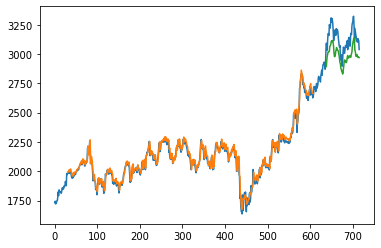

In [50]:

look_back=back_days
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
testPredictPlot[len(train_predict)+(look_back*2):len(df1), :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [51]:
len(test_data)

108

In [52]:
x_input=test_data[len(test_data)-back_days:].reshape(1,-1)
x_input.shape

(1, 30)

In [53]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [54]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=back_days
i=0
while(i<30):
    
    if(len(temp_input)>back_days):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7772315740585327], [0.7461361885070801], [0.7087583541870117], [0.6665223836898804], [0.6263258457183838], [0.5952468514442444], [0.5745555758476257], [0.5614719986915588], [0.5547851324081421], [0.5538558959960938], [0.5570158362388611], [0.5630053877830505], [0.571785032749176], [0.5834957361221313], [0.5977942943572998], [0.6138016581535339], [0.6305184960365295], [0.6468642354011536], [0.6618441939353943], [0.6747470498085022], [0.6842806935310364], [0.6904577612876892], [0.6934530138969421], [0.6936795115470886], [0.6919506192207336], [0.6891558766365051], [0.6862007975578308], [0.6833093762397766], [0.6806606650352478], [0.6778886318206787]]


In [55]:
day_new=np.arange(1,back_days+1)
day_pred=np.arange(back_days+1,(back_days+31))

In [56]:
len(day_pred)

30

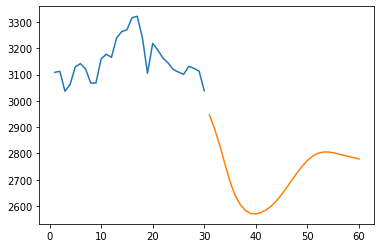

In [57]:

plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-back_days:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

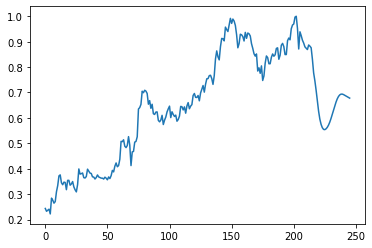

In [58]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[500:])

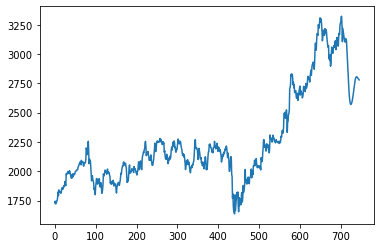

In [59]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)